# Create a Custom Callback in Keras

### 1. Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.1


### 2. Loading and preprocessing data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.reshape(x_train, (60000, 784))/255.
x_test = np.reshape(x_test, (10000, 784))/255.

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

### 3. Model

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


### 4. Creating the Callback

In [5]:
class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, fraction):
        super(CustomCallback, self).__init__()
        
        self.fraction = fraction
        self.train_a = []
        self.val_a = []
        
        with open('log.txt', 'w') as f:
            f.write('Start of log\n')
        
        self.fig = plt.figure(figsize=(4, 3))
        self.ax = plt.subplot(1, 1, 1)
        plt.ion()
    
    def on_train_begin(self, logs=None):
        self.fig.show()
        self.fig.canvas.draw()
    
    def on_train_end(self, logs=None):
        with open('log.txt', 'a') as f:
            f.write('End of log\n')
    
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.fraction * tf.keras.backend.get_value(self.model.optimizer.lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        with open('log.txt', 'a') as f:
            f.write('Epoch:{:02d}, Learning Rate:{:.4f}, '.format(epoch, lr))
        
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        
        with open('log.txt', 'a') as f:
            f.write('Train Acc:{:.3f}, Val Acc:{:.3f}\n'.format(train_acc , val_acc))
        
        self.ax.clear()
        self.ax.plot(range(epoch + 1), self.train_a, label='Training Acc')
        self.ax.plot(range(epoch + 1), self.val_a, label='Validation Acc')
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()

### 6. Training the Model

<IPython.core.display.Javascript object>


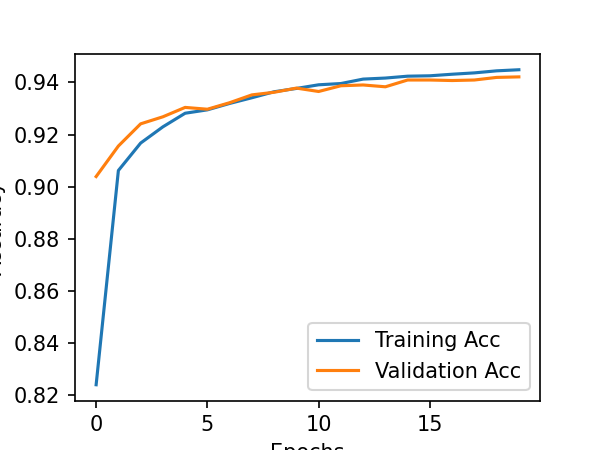

In [6]:
cc = CustomCallback(fraction=0.9)

In [7]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, verbose=False,
    callbacks=[cc]
)